# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


# Parameters

In [181]:
m = 2
A = 0.001#0.049375#5#0.0492645084166179#0.049264507293701174#0.049264508247375494#0.04925#0.0493#0.001#0.049375#0.07#0.05#0.1124921875#0.125
run = 1

1

In [182]:
0.04925 dispersa
0.049375 marked as critical

LoadError: syntax: extra token "dispersa" after end of expression

In [183]:
(0.04925+0.0495)/2

0.049375

In [184]:
049375+

LoadError: syntax: incomplete: premature end of input

In [185]:
global loggrid=true
global bisection=false
global meshrefinement=false;

In [186]:
using Quadmath, Printf

res=m;
N=2.0^m*200.0/2.0#Nt=2.0^m*1000.0/2.0
Xf=1.0#Float128(1.0);

dx=Xf/N#Float128(Xf/N);
if loggrid==false
    dt=0.5*round(dx,digits=10)
else
    dt=0.1*round(dx,digits=10)
end
Nt=2.0^m*200.0/2.0#Nt=2.0^m*1000.0/2.0
Tf=Nt*dt; #final time
#print(Tf)

In [187]:
print(N)

400.0

In [188]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)

dx =0.0025
dt =0.00025
dx/dt =10.0


In [189]:
global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"
#global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

# Grid

In [190]:
using Printf
include("./ScalarField.jl");

In [191]:
ori=0.0#Float128(0.0)#0.0;
initX1 = nothing
N=int(N)
initX1=range(ori, stop=Xf, step=dx);
#initX1=create_range(ori,Xf,dx,N)
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)
#initX=create_range(ori-3.0*dx,Xf+3.0*dx,dx,N+6)

L=length(initX);
println("step size is  ", dx)
println("the time step is ", dt)

if loggrid==true
    global originalX=initX
    xtilde=gridfunc(initX1)
    initX1=xtilde
    initX=collect(initX)
    initX[4:L-3]=xtilde
end;

step size is  0.0025
the time step is 0.00025


# Initial data of m β Ψ and Ψ,x

In [192]:
using Dierckx
using Quadmath


####
#initm=Array{Float128}(undef, L)
#initbeta=Array{Float128}(undef, L)
#initpsi=Array{Float128}(undef, L)
#initderpsi=Array{Float128}(undef, L)
initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initderpsi=zeros(L);

state_array=[initm initbeta initpsi initderpsi initX];

#PSI
r0=0.7#0.01#0.7#0.01#0.7#0.7#0.7#0.01#0.7#0.3
sigma=0.3
initpsi[4:L-3] = init_gaussian(initX1,r0,sigma,A)

state_array[:,3] = initpsi
state_array = ghost(state_array)

#PSI,X FROM PSI
initderpsi[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)
state_array[:,4] = initderpsi
state_array=ghost(state_array)

####

derpsi_func = Spline1D(initX[4:L-3], state_array[4:L-3,4],  k=4);

In [193]:
y0=[0 0 0]

state_array[4:L-3,1:3] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,derpsi_func,state_array[:,:]);

state_array = ghost(state_array);

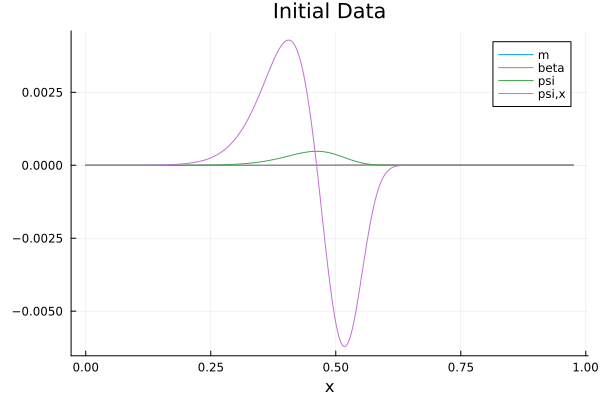

In [194]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX[4:L-3], state_array[4:L-3,1:4], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [195]:
using CSV, Tables, Printf
#CSV.write(dir*"/time_step0.csv", Tables.table(transpose(Matrix(state_array))), writeheader=false)
CSV.write(dir*"/res$res/time_step0.csv", Tables.table(state_array), writeheader=false)

global files=["m", "beta", "psi", "derpsi"]

print_muninn(files, 0, state_array[:,1:5],res,"w")

In [196]:
time=0.0
criticality=0.0
explode=0.0
evol_stats = [criticality A sigma r0 time explode run]
monitor_ratio = zeros(L)
CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "time", "explode", "run"])

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv"

In [197]:
ginit=speed(initX,state_array[:,1],state_array[:,2])
println(update_dt(initX,state_array[:,1],state_array[:,2],dx,ginit)/dt)

0.19986364998982553


In [199]:
using Base.Threads
Threads.nthreads()

4

 ## Time evolution

In [200]:
#global dt = 5e-5/2/2/2 #RES3
global dt = 5e-5/2/2

1.25e-5

fixed grid

In [ ]:
finaltime=1.3#1.6#2#1.3#0.08*2#0.005*10*5#1#0.9#0.8#0.04*5*4#length(T)-1
evol_stats, T_interp = timeevolution(state_array,finaltime,run);#timeevolution(state_array,finaltime,dir*"/res$res",run,auxstate_array);
#CSV.write(dir*"/timearray$res.csv", Tables.table(T_interp), writeheader=false);



iteration 100 dt is 1.25e-5, t=0.0012499999999999994 speed is 0.4999875089119545, dx/dt=200.0


iteration 200 dt is 1.25e-5, t=0.002499999999999992 speed is 0.4999875089119545, dx/dt=200.0


iteration 300 dt is 1.25e-5, t=0.0037499999999999842 speed is 0.4999875089119545, dx/dt=200.0


iteration 400 dt is 1.25e-5, t=0.005000000000000015 speed is 0.4999875089119545, dx/dt=200.0


iteration 500 dt is 1.25e-5, t=0.006250000000000051 speed is 0.4999875089119545, dx/dt=200.0


iteration 600 dt is 1.25e-5, t=0.0075000000000000865 speed is 0.4999875089119545, dx/dt=200.0


iteration 700 dt is 1.25e-5, t=0.008750000000000122 speed is 0.4999875089119545, dx/dt=200.0


iteration 800 dt is 1.25e-5, t=0.010000000000000158 speed is 0.4999875089119545, dx/dt=200.0


iteration 900 dt is 1.25e-5, t=0.011250000000000194 speed is 0.4999875089119545, dx/dt=200.0


iteration 1000 dt is 1.25e-5, t=0.01250000000000023 speed is 0.4999875089119545, dx/dt=200.0


iteration 1100 dt is 1.25e-5, t=0.01375000000



iteration 8800 dt is 1.25e-5, t=0.10999999999998993 speed is 0.4999875089119545, dx/dt=200.0


iteration 8900 dt is 1.25e-5, t=0.11124999999998979 speed is 0.4999875089119545, dx/dt=200.0


iteration 9000 dt is 1.25e-5, t=0.11249999999998965 speed is 0.4999875089119545, dx/dt=200.0


iteration 9100 dt is 1.25e-5, t=0.11374999999998951 speed is 0.4999875089119545, dx/dt=200.0


iteration 9200 dt is 1.25e-5, t=0.11499999999998937 speed is 0.4999875089119545, dx/dt=200.0


iteration 9300 dt is 1.25e-5, t=0.11624999999998924 speed is 0.4999875089119545, dx/dt=200.0


iteration 9400 dt is 1.25e-5, t=0.1174999999999891 speed is 0.4999875089119545, dx/dt=200.0


iteration 9500 dt is 1.25e-5, t=0.11874999999998896 speed is 0.4999875089119545, dx/dt=200.0


iteration 9600 dt is 1.25e-5, t=0.11999999999998882 speed is 0.4999875089119545, dx/dt=200.0


iteration 9700 dt is 1.25e-5, t=0.12124999999998869 speed is 0.4999875089119545, dx/dt=200.0


iteration 9800 dt is 1.25e-5, t=0.122499999999988



iteration 17400 dt is 1.25e-5, t=0.2174999999999781 speed is 0.4999875089119545, dx/dt=200.0


iteration 17500 dt is 1.25e-5, t=0.21874999999997796 speed is 0.4999875089119545, dx/dt=200.0


iteration 17600 dt is 1.25e-5, t=0.21999999999997782 speed is 0.4999875089119545, dx/dt=200.0


iteration 17700 dt is 1.25e-5, t=0.2212499999999777 speed is 0.4999875089119545, dx/dt=200.0


iteration 17800 dt is 1.25e-5, t=0.22249999999997755 speed is 0.4999875089119545, dx/dt=200.0


iteration 17900 dt is 1.25e-5, t=0.2237499999999774 speed is 0.4999875089119545, dx/dt=200.0


iteration 18000 dt is 1.25e-5, t=0.22499999999997727 speed is 0.4999875089119545, dx/dt=200.0


iteration 18100 dt is 1.25e-5, t=0.22624999999997714 speed is 0.4999875089119545, dx/dt=200.0


iteration 18200 dt is 1.25e-5, t=0.227499999999977 speed is 0.4999875089119545, dx/dt=200.0


iteration 18300 dt is 1.25e-5, t=0.22874999999997686 speed is 0.4999875089119545, dx/dt=200.0


iteration 18400 dt is 1.25e-5, t=0.22999999



iteration 26000 dt is 1.25e-5, t=0.3250000000001328 speed is 0.49998750891195454, dx/dt=200.0


iteration 26100 dt is 1.25e-5, t=0.32625000000013543 speed is 0.49998750891195454, dx/dt=200.0


iteration 26200 dt is 1.25e-5, t=0.32750000000013807 speed is 0.49998750891195454, dx/dt=200.0


iteration 26300 dt is 1.25e-5, t=0.3287500000001407 speed is 0.49998750891195454, dx/dt=200.0


iteration 26400 dt is 1.25e-5, t=0.33000000000014335 speed is 0.49998750891195454, dx/dt=200.0


iteration 26500 dt is 1.25e-5, t=0.331250000000146 speed is 0.49998750891195454, dx/dt=200.0


iteration 26600 dt is 1.25e-5, t=0.3325000000001486 speed is 0.49998750891195454, dx/dt=200.0


iteration 26700 dt is 1.25e-5, t=0.33375000000015126 speed is 0.49998750891195454, dx/dt=200.0


iteration 26800 dt is 1.25e-5, t=0.3350000000001539 speed is 0.49998750891195454, dx/dt=200.0


iteration 26900 dt is 1.25e-5, t=0.33625000000015653 speed is 0.49998750891195454, dx/dt=200.0


iteration 27000 dt is 1.25e-5, t=0

 ## Movie of the evolution

[ Info: Saved animation to /home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif


Plots.AnimatedGif("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif")
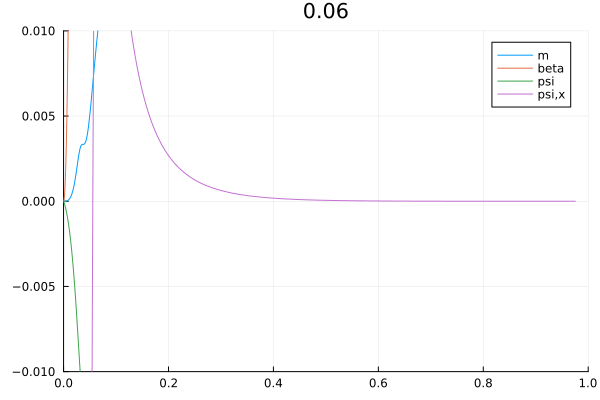

In [28]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 119000:500:147434#870
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    
    #functions3=DataFrame(CSV.File("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/bisectionsearch/run1"*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    temp=round(n*dt,digits=2)
    plot!(initX1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"], title="$temp", ylim=[-0.01, 0.01],xlim=[0, 1])#, xlim=[0, 0.1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 10)

In [115]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 10:10:1000#length(T)-1
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/monitor_ratio$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
    
    plot!(initX1, [plot1], labels=["monitor ratio"], ylim=[0, 1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 5)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res2/monitor_ratio10.csv" is not a valid file or doesn't exist

# New test

In [237]:
include("./ScalarField.jl");

function ff(x)

    return x^2

end
function grid(x)

    return(1/2+1/2*cos(pi*(1-0.9*x)))

end;

In [238]:
res=1

dx=0.1

x=range(-3*dx,1+3*dx,step=dx)

y=ff.(x);

In [239]:
L=length(x)

aux=zeros(L)


for i in 4:L-3

    aux[i]=Dertest(y,i,x)

end

println(aux[4:L-3]);
xnew=grid.(x)
ynew=ff.(xnew);

[3.469446951953615e-16, 0.19999999999999996, 0.3999999999999998, 0.6000000000000004, 0.8, 1.0, 1.2, 1.3999999999999995, 1.6000000000000003, 1.8000000000000018, 1.9999999999999978]


In [240]:
spl=Spline1D(xnew[4:L-3],ynew[4:L-3],k=4)
auxnew=zeros(L);

for i in 4:L-3
    auxnew[i]=unevenDer(ynew,i,xnew,spl)
end

println(" ")
println(auxnew[4:L-3])
println(" ")
println(2 .* xnew[4:L-3])

WWWWWWWWWWWWWWWWWWWWAAAAAAAAA 
[1.8494949330273436e-15, 0.043885351791287275, 0.15567207449798512, 0.33868813467634756, 0.5742207084349278, 0.8435655349597687, 1.1253332335643045, 1.3971478906347807, 1.6374239897486917, 1.8270805742745604, 1.9510565162951545]
 
[0.0, 0.039706314323056935, 0.15567207449798492, 0.3386881346763483, 0.5742207084349277, 0.8435655349597689, 1.1253332335643045, 1.3971478906347805, 1.63742398974869, 1.8270805742745622, 1.9510565162951536]


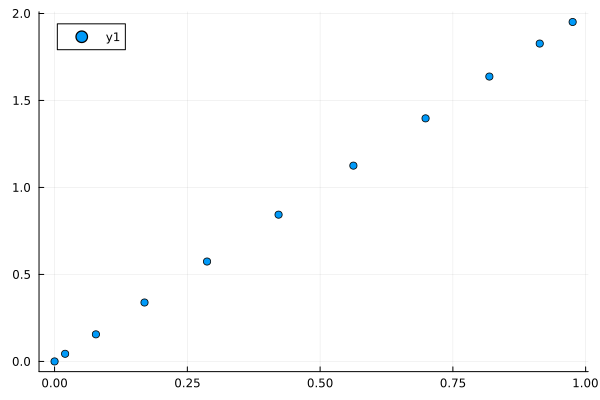

In [243]:

#plot(x,y)

scatter(xnew[4:L-3],auxnew[4:L-3])#,xlim=[0,0.2])

#plot(x[4:L-3],aux[4:L-3])

In [242]:
auxnew[L-3]

1.9510565162951545